<a href="https://colab.research.google.com/github/ching-wong/my_notebooks/blob/main/Custom_Models_Layers_and_Loss_Functions_with_TensorFlow/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Models, Layers, and Loss Functions with TensorFlow - Week 4



>[Custom Models, Layers, and Loss Functions with TensorFlow - Week 4](#scrollTo=VqW8A7V0q51z)

>>[Model revisited](#scrollTo=EhEvfZawXzVR)

>>[Defining a model as a class](#scrollTo=Z4kUZREFafQ_)

>>[Residual networks (Resnet)](#scrollTo=VXU4TFkYjF4K)

>>[Resnet-18](#scrollTo=LPztUC0jnIRt)



## Model revisited

Using functional API, one can easily define complex architecture such as the following model, with two inputs and two outputs.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deep_input (InputLayer)   │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ first_dense (Dense)       │ (None, 128)            │         64,128 │ deep_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wide_input (InputLayer)   │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ second_dense (Dense)      │ (None, 64)             │          8,256 │ first_dense[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 124)            │              0 │ wide_input[0][0],      │
│                           │                        │                │ second_dense[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output1 (Dense)           │ (None, 10)             │          1,250 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output2 (Dense)           │ (None, 1)              │             65 │ second_dense[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 73,699 (287.89 KB)

 Trainable params: 73,699 (287.89 KB)

 Non-trainable params: 0 (0.00 B)

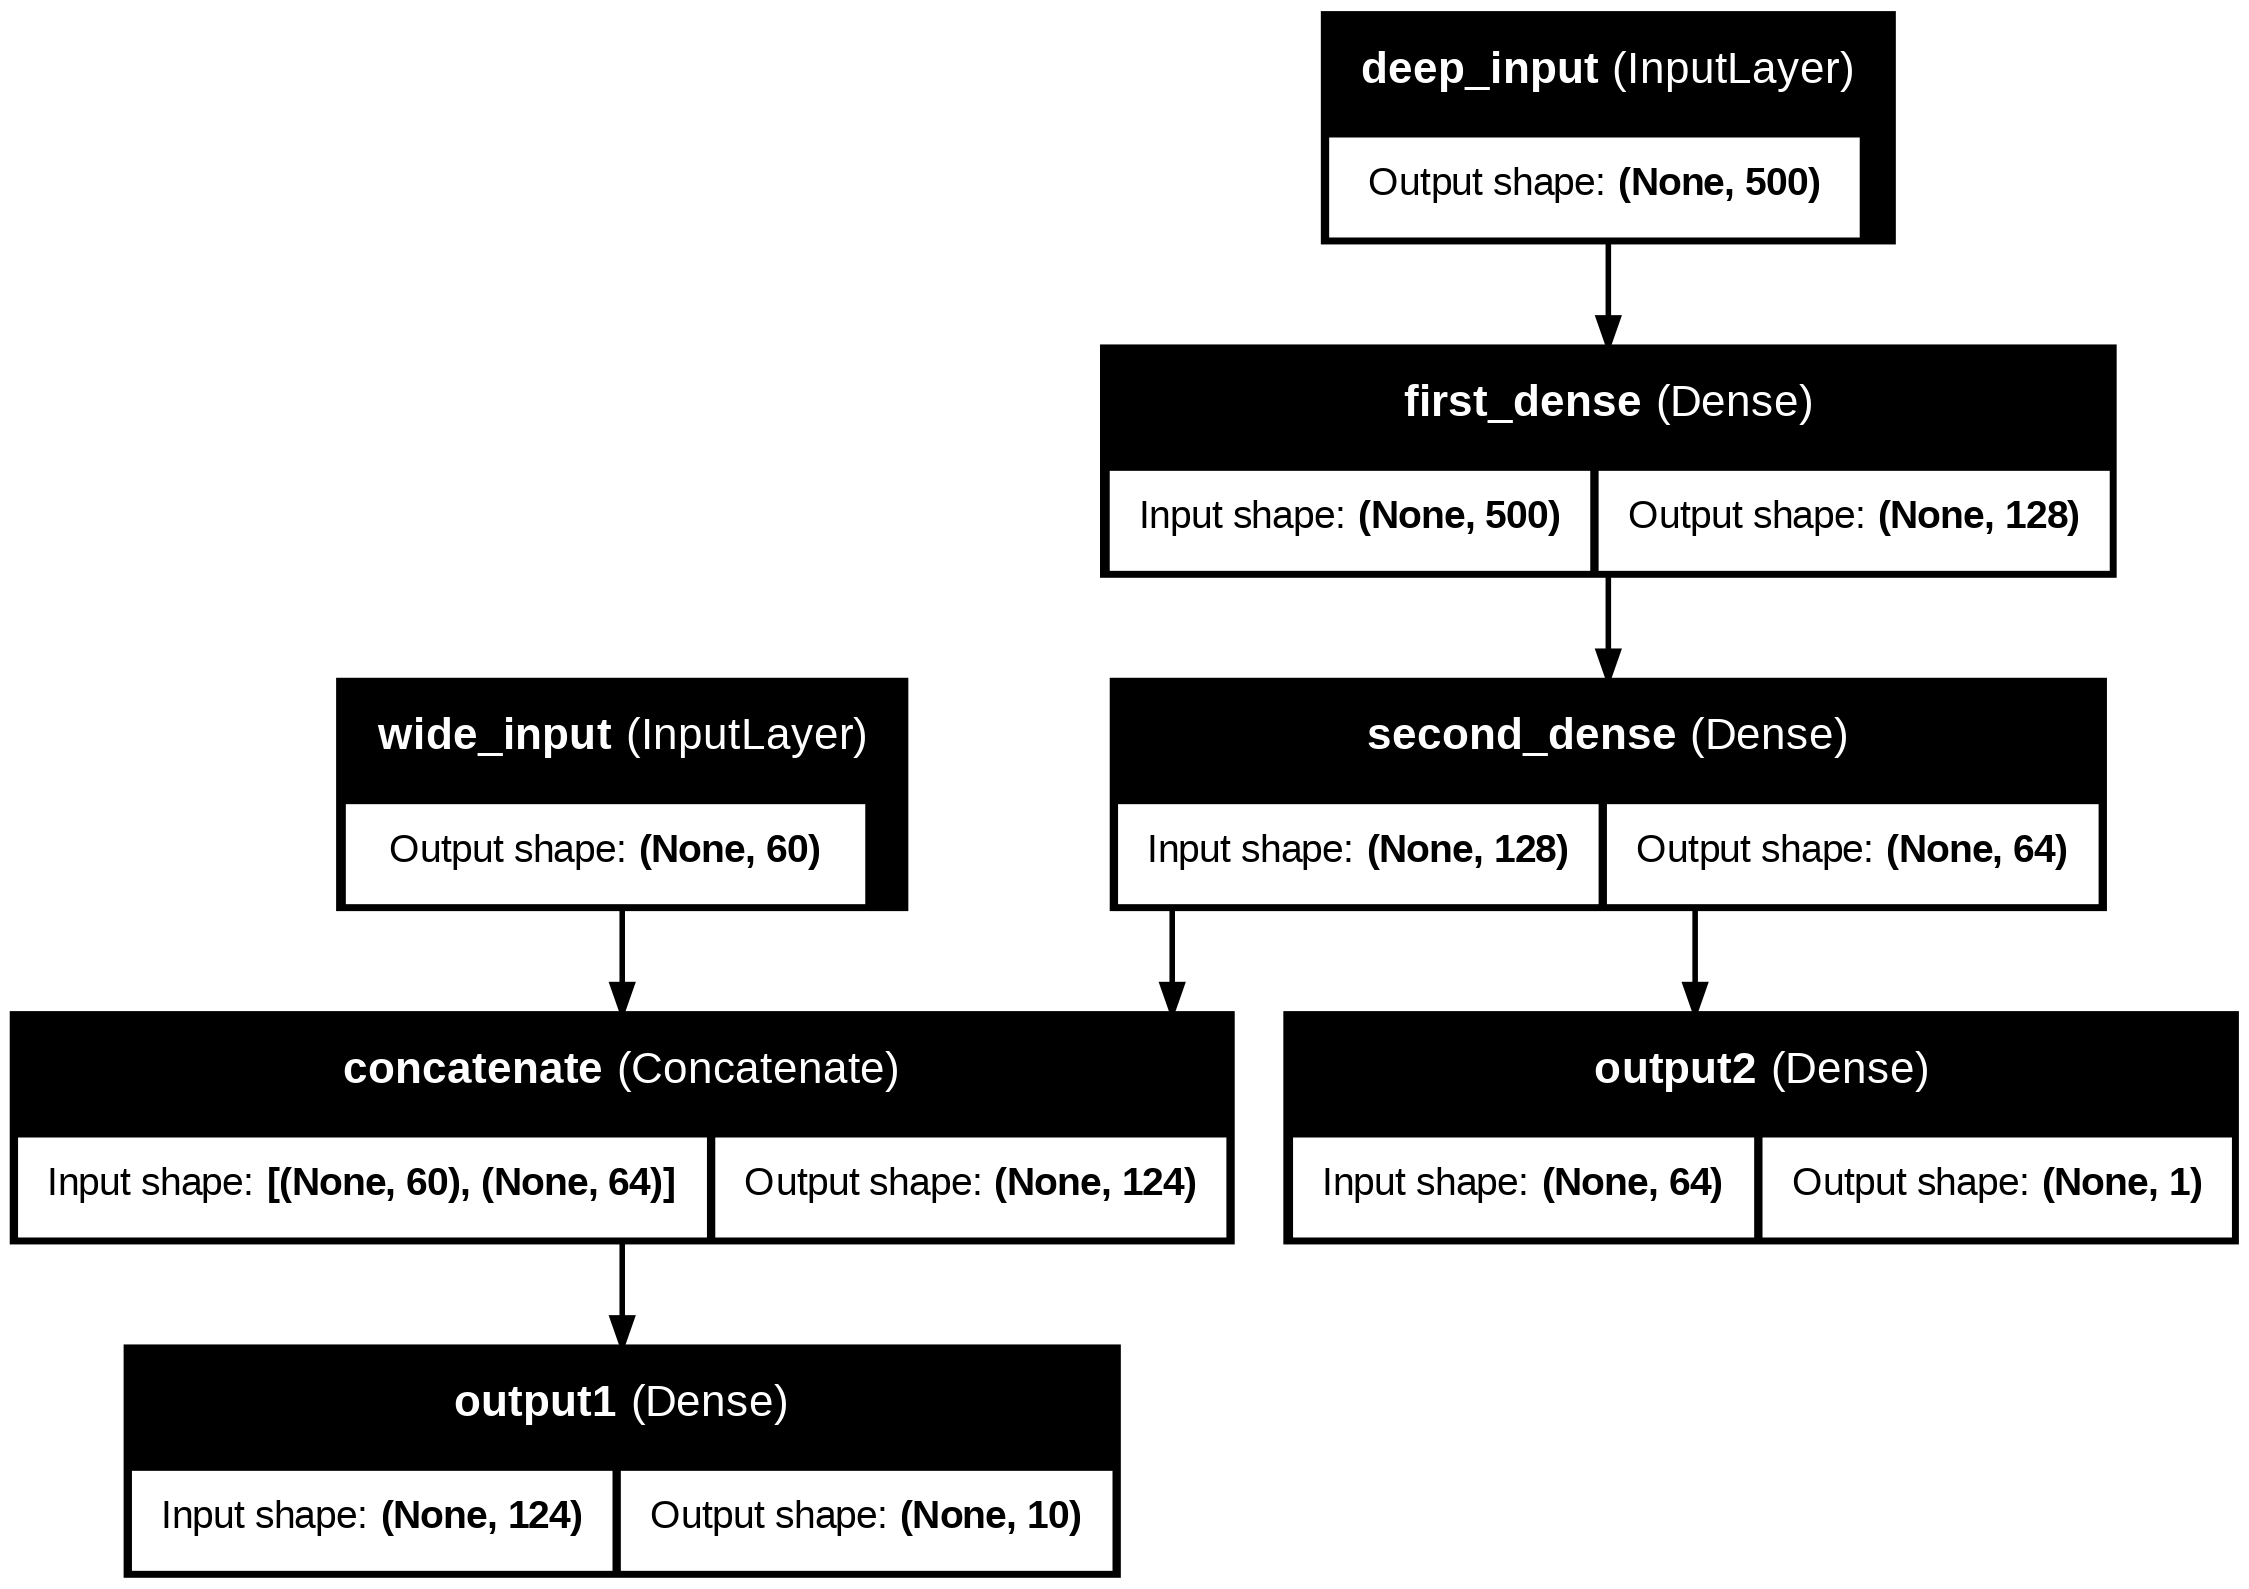

In [1]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

input1 = Input(shape=[60], name = "wide_input")
input2 = Input(shape=[500], name = "deep_input")

dense1 = Dense(128, activation = "relu", name = "first_dense")(input2)
dense2 = Dense(64, activation = "relu", name = "second_dense")(dense1)
concat = concatenate([input1, dense2])

output1 = Dense(10, activation = "softmax", name = "output1")(concat)
output2 = Dense(1, name = "output2")(dense2)

model = Model(inputs = [input1, input2], outputs = [output1, output2])

model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)


## Defining a model as a class

For tidying the code and reusing the model in the future, one can implement the model as a class. Moreover, one is not limited to static declaration of the model and can add more complex structure in a class (such as loop, if-else).

This class should inherit from the class Model, and contains at least the following two methods:

* init: extends the Model class, creates internal variables (states),

* call: runs when the class is constructed, define and return model output.

In [2]:
class WideAndDeepModel(Model):

  def __init__(self, units = [128, 64, 10, 1], activation = ["relu", "softmax"], **kwargs):
    super().__init__(**kwargs)
    self.dense1 = Dense(units[0], activation = activation[0], name = "first_dense")
    self.dense2 = Dense(units[1], activation = activation[0], name = "second_dense")
    self.output1 = Dense(units[2], activation = activation[1], name = "output1")
    self.output2 = Dense(units[3], name = "output2")

  def call(self, inputs):
    input1, input2 = inputs
    dense1 = self.dense1(input2)
    dense2 = self.dense2(dense1)
    concat = concatenate([input1, dense2])
    output1 = self.output1(concat)
    output2 = self.output2(dense2)
    return (output1, output2)

Now we can use the model we just defined and should get the same result as above.

The summary looks much simpler because Keras does not have detailed knowledge of the custom layers in WideAndDeepModel. Instead, it treats the entire model as a single layer.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ wide_input (InputLayer)   │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deep_input (InputLayer)   │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wide_and_deep_model       │ [(None, 10), (None,    │         73,699 │ wide_input[0][0],      │
│ (WideAndDeepModel)        │ 1)]                    │                │ deep_input[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 73,699 (287.89 KB)

 Trainable params: 73,699 (287.89 KB)

 Non-trainable params: 0 (0.00 B)

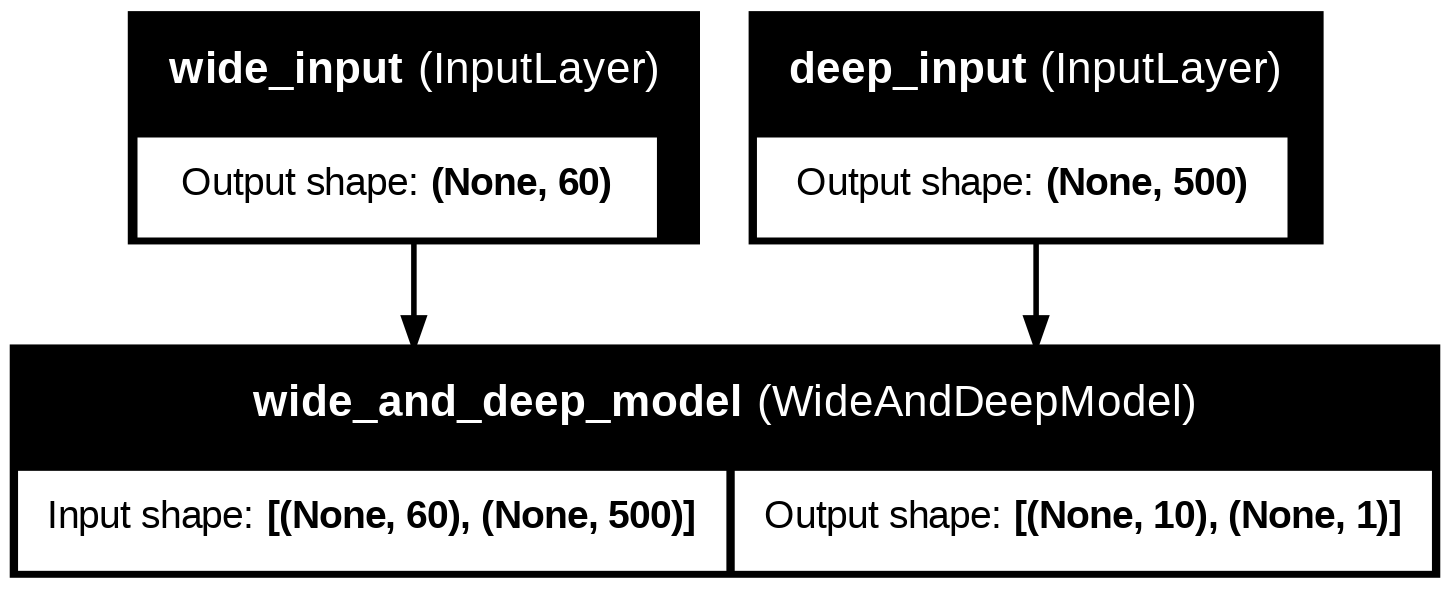

In [3]:
model2 = Model(inputs=[input1, input2], outputs=WideAndDeepModel()([input1, input2]))

model2.summary()

plot_model(model2, show_shapes=True, show_layer_names=True)

## Residual networks (Resnet)

It can increase the depth of the network, without losing accuracy.

As networks get deeper, gradients during backpropagation become very small.
This makes training slow, and the earlier layers stop learning effectively.
ResNet solves this with skip connections (residual connections), allowing gradients to flow through the network more easily.

Instead of a regular transformation $Y=F(X)$, ResNet introduces a shortcut connection $Y=F(X)+X$. This means even if a deeper layer learns nothing (gradient close to zero), the network can still pass information forward.

Here we have 2 simple residual networks using CNN and DNN, respectively.

In [4]:
from tensorflow.keras.layers import Conv2D

class CNNResidual(Model):

  def __init__(self, num_layers, filters, activation, **kwargs):
    super().__init__(**kwargs)
    self.conv2d = [Conv2D(filters, (3,3), activation = activation) for _ in range(num_layers)]

  def call(self, inputs):
    x = inputs
    for layer in self.conv2d:
      x = layer(x)

    return inputs + x

In [5]:
class DNNResidual(Model):

  def __init__(self, num_layers, units, activation, **kwargs):
    super().__init__(**kwargs)
    self.dense = [Dense(units, activation = activation) for _ in range(num_layers)]

  def call(self, inputs):
    x = inputs
    for layer in self.dense:
      x = layer(x)

    return inputs + x

We can now easily create a model with one CNN residual, followed by three DNN residual.

In [6]:
class MyResidual(Model):

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.dense = Dense(30, activation = "relu")
    self.block1 = CNNResidual(2, 32, "relu")
    self.block2 = DNNResidual(2, 64, "relu")
    self.out = Dense(1)

  def call(self, inputs):
    x = self.dense(inputs)
    x = self.block1(x)
    for _ in range(3):
      x = self.block2(x)
    x = self.out(x)
    return x

## Resnet-18

1.   7 by 7 convolution layer
2.   batch normalisation
3.   activation
4.   3 by 3 max pooling

Batch Normalization (BatchNorm) is typically applied after a Conv2D layer and before the activation function like ReLU. This helps to keep the activations more stable and allows the network to train faster and more effectively.

Note: Max pooling performs a non-linear operation by itself, so no additional activation function is needed here.

After that it's a combination of 5 and 6 below.

5. indentity ResNet blocks (X -> 3x3 Conv -> Batch Norm -> ReLu -> 3x3 Conv -> Batch Norm -> + X -> ReLu)

6. indentity ResNet blocks with 1x1 Conv (X -> 3x3 Conv -> Batch Norm -> ReLu -> 3x3 Conv -> Batch Norm -> + 1x1 Conv(X) -> ReLu)

In [7]:
from tensorflow.keras.layers import BatchNormalization, Activation, Add

class IdResNetBlock(Model):

  def __init__(self, filters, kernel_size, **kwargs):
    super().__init__(**kwargs)
    self.convolution1 = Conv2D(filters, kernel_size)
    self.batchnorm1 = BatchNormalization()

    self.convolution2 = Conv2D(filters, kernel_size)
    self.batchnorm2 = BatchNormalization()

    self.activation = Activation("relu") # it contains no trainable parameters so it can be reused
    self.add = Add()

  def call(self, inputs):
    x = inputs

    x = self.convolution1(x)
    x = self.batchnorm1(x)
    x = self.activation(x)

    x = self.convolution2(x)
    x = self.batchnorm2(x)
    x = self.activation(x)

    x = self.add([x, inputs])
    x = self.activation(x)
    return x


First we build mini-ResNet, with only two indentity ResNet blocks.

Note: GlobalAveragePooling2D reduces the spatial dimensions (height and width) of a feature map to 1x1, by taking the average.

In [8]:
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

class MiniResNet(Model):

  def __init__(self, num_classes, **kwargs):
    super().__init__(**kwargs)
    self.convolution= Conv2D(64, (7,7), padding = "same")
    self.batchnorm = BatchNormalization()
    self.activation = Activation("relu")
    self.maxpooling = MaxPooling2D((3,3))

    self.id1 = IdResNetBlock(64, (3,3))
    self.id2 = IdResNetBlock(64, 3) # same as above

    self.globalpooling = GlobalAveragePooling2D()
    self.classifier = Dense(num_classes, activation = "softmax")

  def call(self, inputs):
    x = inputs
    x = self.convolution(x)
    x = self.batchnorm(x)
    x = self.activation(x)
    x = self.maxpooling(x)

    x = self.id1(x)
    x = self.id2(x)

    x = self.globalpooling(x)
    x = self.classifier(x)
    return x